# Registration Evaluation

In [ ]:
import os
import cv2
import kornia as K
import kornia.feature as KF
import kornia.geometry.transform as KT
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import torch
import torch.nn.functional as F
import skimage as ski

from utils import *
from loftr import plot_image_pair, plot_overlay
from DatasetTools.LeafImageSeries import LeafDataset

In [2]:
base_dir = '../leaf-image-sequences'
uid_dir = base_dir + '/processed/reg'
leaf_uids = [
    name for name in os.listdir(uid_dir)
    if os.path.isdir(os.path.join(uid_dir, name))
]

In [2]:
leaf = LeafDataset(
    base_dir='../leaf-image-sequences',
    # leaf_uid="ESWW0090057_18", 
    leaf_uid="ESWW0070020_1", 
    # load=('images', 'rois', 'tforms', 'target_masks', 'leaf_masks', 'instance_masks', 'det_masks', 'seg_masks', 'target_images', "keypoints")
    load=('target_images', 'target_masks', 'leaf_masks'), #'images', 'rois', "keypoints",
    verbose=True
)

Initializing dataset...
Getting Series...
Getting paths...
Extracting IDs...
Removing duplicate IDs...
Filtering by leaf_uid...
Compiling list...
Loading requested values...
Loading Target Masks...
Loading Leaf Masks...
Loading target images...


In [3]:
def fetch_image_pair(leaf, fixed_img_ind, moving_img_ind, method):
    if method == "Pairwise Affine":
        fixed_img = convert_image_to_tensor(leaf.target_images[fixed_img_ind])
        moving_img = convert_image_to_tensor(leaf.target_images[moving_img_ind])
        return fixed_img, moving_img
    elif method == "LoFTR + TPS":
        raise NotImplementedError
    
    else:
        raise ValueError(f'Unknown registration method {method}')

In [ ]:
def fetch_image_mask_pair(leaf, fixed_img_ind, moving_img_ind, method):
    if method == "Pairwise Affine":
        fixed_img = convert_image_to_tensor(leaf.target_images[fixed_img_ind])
        fixed_mask = convert_image_to_tensor(leaf.target_masks[fixed_img_ind])
        fixed_mask[fixed_mask != 0] = 1

        moving_img = convert_image_to_tensor(leaf.target_images[moving_img_ind])
        moving_mask = convert_image_to_tensor(leaf.target_masks[moving_img_ind])
        moving_mask[moving_mask != 0] = 1
        return fixed_img, moving_img, fixed_mask, moving_mask
    elif method == "LoFTR + TPS":
        raise NotImplementedError
    
    else:
        raise ValueError(f'Unknown registration method {method}')

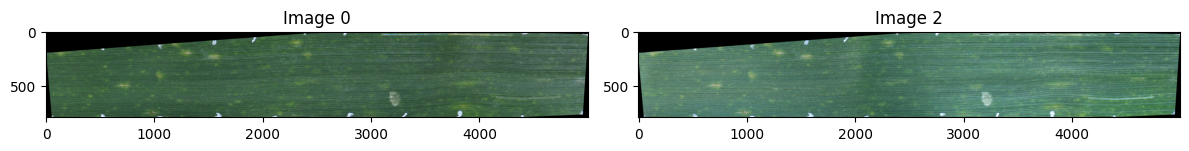

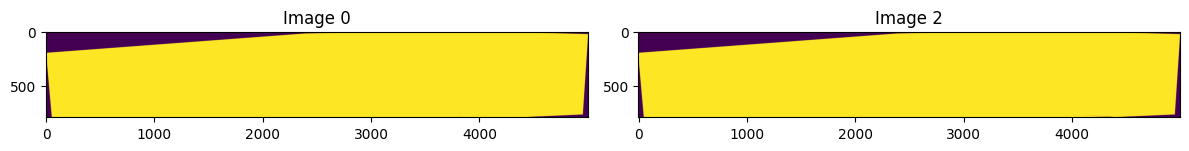

In [125]:
fixed, moving, fixed_mask, moving_mask = fetch_image_mask_pair(leaf, 1, 2, "Pairwise Affine")
fig, ax = plot_image_pair(fixed, moving, 0, 2)
fig.show()
fig, ax = plot_image_pair(fixed_mask, moving_mask, 0, 2)
fig.show()

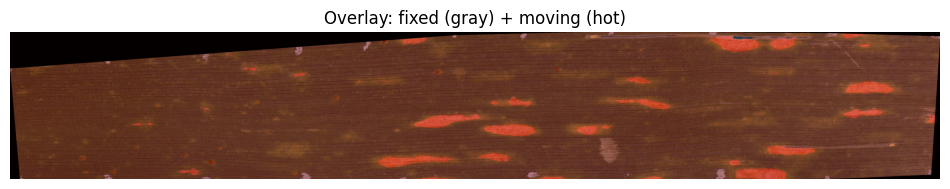

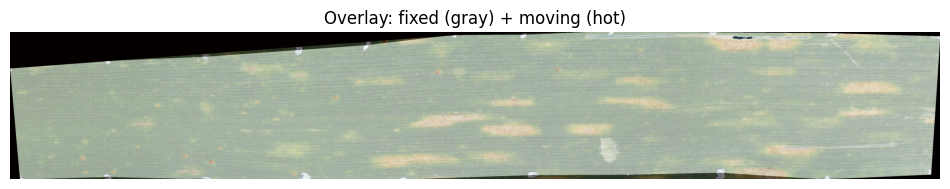

tensor([0., 1.])


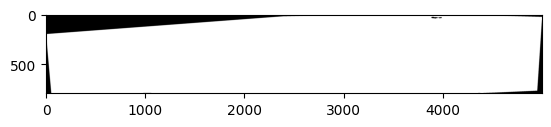

In [27]:
ind = 10
fig = plot_overlay(leaf.target_images[ind], leaf.target_masks[ind])
fig = plot_overlay(leaf.target_images[ind], leaf.leaf_masks[ind])
mask = convert_image_to_tensor(leaf.target_masks[ind])
mask[mask!=0] = 1
print(mask.unique())
# plt.imshow(leaf.target_masks[ind])
plt.imshow(convert_img_tensor_to_numpy(mask), cmap='gray', vmin=0, vmax=1)
# plot_image_pair(convert_image_to_tensor(leaf.target_images[ind]), convert_image_to_tensor(leaf.leaf_masks[ind]))

## Evaluation Metrics

### MSE

In [48]:
def weighted_average(tensor, weights):
    weighted_sum = torch.sum(tensor*weights)
    weight_sum = torch.sum(weights)
    weighted_average = weighted_sum / weight_sum
    return weighted_average

In [74]:
def mse_masked(img1, img1_mask, img2, img2_mask, reduction="mean", mask_mode='either'):
    img1 = convert_image_to_tensor(img1)
    img2 = convert_image_to_tensor(img2)
    img1_mask = convert_image_to_tensor(img1_mask)
    img2_mask = convert_image_to_tensor(img2_mask)


    if mask_mode == 'either':
        # consider all pixels where at least one image is valid
        mask = torch.logical_or(img1_mask, img2_mask)
    elif mask_mode == 'both':
        # consider all pixels where both images are valid
        mask = torch.logical_and(img1_mask, img2_mask)
    else:
        raise ValueError(f"Unknown mask_mode {mask_mode}. Expected 'either' or 'both'.")

    if mask.shape[1] == 1:
        mask = K.color.grayscale_to_rgb(mask)
        
    # squared_diff = (img1)
    # mse_loss = torch.nn.MSELoss(reduction=reduction)
    return torch.nn.functional.mse_loss(img1, img2, reduction=reduction, weight=mask)

In [75]:
# sanity check
print(f"Standard MSE: {mse(fixed, moving)}")
print(f"'Masked' MSE: {mse_masked(fixed, torch.ones_like(convert_image_to_tensor(fixed)), moving, torch.ones_like(convert_image_to_tensor(moving)))}")

print(f"Masked MSE: {mse_masked(fixed, fixed_mask, moving, moving_mask)}")

Standard MSE: 0.01612808369100094
'Masked' MSE: 0.01612808369100094
Masked MSE: 0.017626041546463966


### NCC

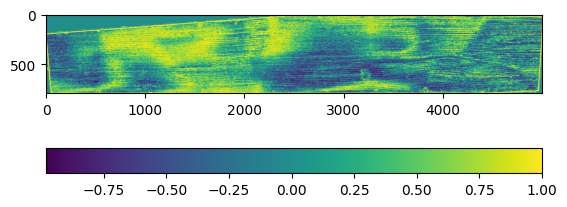

In [47]:
res = local_ncc(fixed, moving, reduction='none')
img = plt.imshow(K.tensor_to_image(res))
plt.colorbar(img, orientation='horizontal', fraction=.1)
plt.show()

In [ ]:
def ncc_masked(img1, img1_mask, img2, img2_mask, reduction="mean",  mask_mode='either'):
    img1 = convert_image_to_tensor(img1)
    img2 = convert_image_to_tensor(img2)
    img1_mask = convert_image_to_tensor(img1_mask)
    img2_mask = convert_image_to_tensor(img2_mask)

    # Convert to grayscale
    img1 = K.color.rgb_to_grayscale(img1)
    img2 = K.color.rgb_to_grayscale(img2)

    if mask_mode == 'either':
        # consider all pixels where at least one image is valid
        mask = torch.logical_or(img1_mask, img2_mask)
    elif mask_mode == 'both':
        # consider all pixels where both images are valid
        mask = torch.logical_and(img1_mask, img2_mask)
    else:
        raise ValueError(f"Unknown mask_mode {mask_mode}. Expected 'either' or 'both'.")

    if torch.sum(mask) == 0:
        raise ValueError(f"Combined mask is empty.")

    img1_mean = weighted_average(img1, mask)
    img2_mean = weighted_average(img2, mask)
    img1_centered = img1 - img1_mean
    img2_centered = img2 - img2_mean
    std1 = torch.sqrt(weighted_average(torch.pow(img1_centered, 2), mask))
    std2 = torch.sqrt(weighted_average(torch.pow(img2_centered, 2), mask))

    if reduction == 'mean':
        # Full-image NCC        
        return torch.sum(img1_centered * img2_centered * mask) / (std1 * std2 * torch.sum(mask) + 1e-13)

    elif reduction == 'none':
        # Per-pixel NCC map
        img1_norm = img1_centered / (std1 + 1e-13)
        img2_norm = img2_centered / (std2 + 1e-13)
        return img1_norm * img2_norm * mask

    else:
        raise ValueError("reduction must be either 'mean' or 'none'")

In [136]:
# sanity check
print(f"Standard NCC: {ncc(fixed, moving)}")
print(f"'Masked' NCC: {ncc_masked(fixed, torch.ones_like(K.color.rgb_to_grayscale(convert_image_to_tensor(fixed))), moving, torch.ones_like(K.color.rgb_to_grayscale(convert_image_to_tensor(moving))))}")
print(f"Inverted Images: {ncc(img1, img2)}")
print(f"Blackened Images: {ncc(img3, img4)}")

print(f"Masked NCC: {ncc_masked(fixed, fixed_mask, moving, moving_mask)}")
print(f"'and' Masked NCC: {ncc_masked(fixed, fixed_mask, moving, moving_mask, mask_mode='both')}")

Standard NCC: 0.8246079683303833
'Masked' NCC: 0.8246080279350281
Inverted Images: 0.9106995463371277
Blackened Images: 0.956824004650116
Masked NCC: 0.3901742696762085
'and' Masked NCC: 0.3908914029598236


(<Figure size 1200x600 with 2 Axes>,
 array([<Axes: title={'center': 'Image 1'}>,
        <Axes: title={'center': 'Image 2'}>], dtype=object))

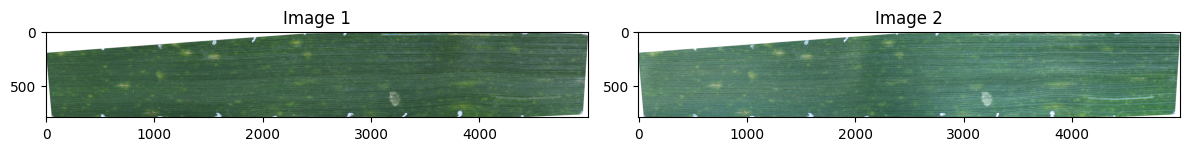

In [123]:
img1 = convert_image_to_tensor(fixed)
img2 = convert_image_to_tensor(moving)
img1[K.color.grayscale_to_rgb(fixed_mask) == 0] = 1
img2[K.color.grayscale_to_rgb(moving_mask) == 0] = 1
plot_image_pair(img1, img2)

(<Figure size 1200x600 with 2 Axes>,
 array([<Axes: title={'center': 'Image 1'}>,
        <Axes: title={'center': 'Image 2'}>], dtype=object))

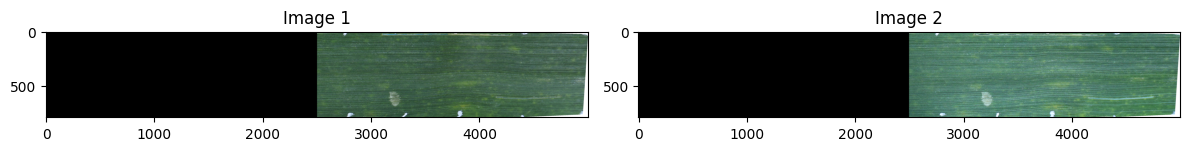

In [135]:
img3 = img1.clone()
img4 = img2.clone()
img3[0,:,:,:2500] = 0
img4[0,:,:,:2500] = 0
plot_image_pair(img3, img4)

#### Local NCC

In [110]:
def local_ncc_masked(img1, img1_mask, img2, img2_mask, window_size=9, mask_mode='either', reduction='mean'):
    img1 = convert_image_to_tensor(img1)
    img2 = convert_image_to_tensor(img2)
    img1_mask = convert_image_to_tensor(img1_mask)
    img2_mask = convert_image_to_tensor(img2_mask)

    # Convert to grayscale
    img1 = K.color.rgb_to_grayscale(img1)
    img2 = K.color.rgb_to_grayscale(img2)

    # construct mask
    if mask_mode == 'either':
        # consider all pixels where at least one image is valid
        mask = torch.logical_or(img1_mask, img2_mask)
    elif mask_mode == 'both':
        # consider all pixels where both images are valid
        mask = torch.logical_and(img1_mask, img2_mask)
    else:
        raise ValueError(f"Unknown mask_mode {mask_mode}. Expected 'either' or 'both'.")

    if torch.sum(mask) == 0:
        raise ValueError(f"Combined mask is empty.")

    # cast mask to float
    mask = mask.to(dtype=img1.dtype)

    kernel = torch.ones(1,1,window_size, window_size, device=img1.device)
    padding = window_size//2

    # local sums
    img1_masked = mask * img1
    img2_masked = mask * img2

    sum_mask  = F.conv2d(mask,  kernel, padding=padding)
    sum1  = F.conv2d(img1_masked, kernel, padding=padding)
    sum2  = F.conv2d(img2_masked, kernel, padding=padding)
    
    # local means
    mean1 = sum1 / (sum_mask + 1e-13)
    mean2 = sum2 / (sum_mask + 1e-13)

    # center
    img1_centered = img1 - mean1
    img2_centered = img2 - mean2

    # weighted second moments
    var1 = F.conv2d(mask * img1_centered * img1_centered, kernel, padding=padding)
    var2 = F.conv2d(mask * img2_centered * img2_centered, kernel, padding=padding)
    cov = F.conv2d(mask * img1_centered * img2_centered, kernel, padding=padding)

    # local stds
    std1 = torch.sqrt(var1)
    std2 = torch.sqrt(var2)

    lncc_map = cov / (std1 * std2 + 1e-13)

    # only count pixels where there is enough valid support
    valid = (sum_mask > 0)

    if reduction == 'mean':
        return lncc_map[valid].mean()
    elif reduction == 'none':
        return lncc_map.squeeze(0).squeeze(0)  # remove batch/channel dims
    else:
        raise ValueError("reduction must be 'mean' or 'none'")


In [111]:
# sanity check
print(f"Standard LNCC: {local_ncc(fixed, moving)}")
print(f"'Masked' LNCC: {local_ncc_masked(fixed, torch.ones_like(K.color.rgb_to_grayscale(convert_image_to_tensor(fixed))), moving, torch.ones_like(K.color.rgb_to_grayscale(convert_image_to_tensor(moving))))}")

print(f"Masked LNCC: {local_ncc_masked(fixed, fixed_mask, moving, moving_mask)}")

test
Standard LNCC: 0.17045828700065613
'Masked' LNCC: 0.16544589400291443
Masked LNCC: 0.15299779176712036


### Mutual Information

In [9]:
def nmi(img1, img2, bins=100):
    img1 = convert_img_tensor_to_numpy(convert_image_to_tensor(img1))
    img2 = convert_img_tensor_to_numpy(convert_image_to_tensor(img2))

    return ski.metrics.normalized_mutual_information(img1, img2, bins=bins)

In [23]:
print(f"MI: {mutual_information(fixed, moving)}")
print(f"NMI: {nmi(fixed, moving)}")

MI: 0.6688255667686462
NMI: 1.1170194007609695


### SSIM

In [8]:
ksim = ssim_kornia(fixed, moving, reduction='none').squeeze(0)
_, skisim = ssim_skimage(fixed, moving, return_img=True)
skisim = convert_image_to_tensor(skisim)
print(f"Kornia: {ksim.shape}")
print(f"Skimage: {skisim.shape}")
print(f"Diff: {torch.mean(ksim-skisim)}")

Kornia: torch.Size([3, 791, 4999])
Skimage: torch.Size([3, 791, 4999])
Diff: 0.0014511715853586793


## Evaluation

In [ ]:
out_file = "registration_eval.csv"

METHOD = "Pairwise Affine"
metrics = {'MSE': mse, 'NCC': ncc, 'MI': mutual_information, 'SSIM': ssim_kornia}

processed_uids = set()

if os.path.exists(out_file):
    with open(csv_path, newline="", mode="r") as f:
        reader = csv.DictReader(f)
        for row in reader:
            if row['registration_method'] == METHOD:
                processed_uids.add(row['leaf_uid'])

with open(out_file, 'a', newline='') as f:
    writer = csv.DictWriter(f, fieldnames=['leaf_uid', 'registration_method', 'fixed_image', 'moving_image']+list(metrics.keys()))
    
    # write header only if file is new
    if f.tell() == 0:
        writer.writeheader()

    for uid in leaf_uids:
        if uid in processed_uids:
                print(f"Leaf {uid} has already been evaluated for {METHOD} registration")
                continue
        
        leaf = LeafDataset(
            base_dir=base_dir,
            leaf_uid=uid, 
            load=('images', 'rois', "keypoints", 'target_images'),
            verbose=False
        )  

        fixed_image_indices = [0,1]
        moving_image_indices = np.arange(len(leaf.images))

        for fixed_img_ind in fixed_img_indices:
            for moving_img_ind in moving_img_indices:

                fixed_img, moving_img = fetch_image_pair(leaf, fixed_img_ing, moving_img_ind, METHOD)
                
                eval_res = {'leaf_uid': uid, 'registration_method': METHOD, 'fixed_image': fixed_img_ind, 'moving_image': moving_img_ind}

                # metric_vals = {}
                for metric_name, metric_func in metrics.items():
                    val = metric(fixed_img, moving_img)
                    # metric_vals.update({metric_name: val})
                    eval_res.update({metric_name: val})

                # eval_res.update(metric_vals)
                writer.writerow(eval_res)

                    